## Options structural break detection - Preprocessing

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pickle_dir = "../results_pickle_format"

## Cboe Options Historical Volume and Put/Call Ratios

In [4]:
from datetime import datetime
dateparser = lambda x: datetime.strptime(x, '%m/%d/%Y')

In [5]:
data_path = '../options_historical_data'

In [6]:
# index option
df_idxo = pd.read_csv(f"{data_path}/indexpc.csv", sep=',', skiprows=2, parse_dates=['DATE'], date_parser=dateparser)

# equity option 
df_eqto = pd.read_csv(f"{data_path}/equitypc.csv", sep=',', skiprows=2, parse_dates=['DATE'], date_parser=dateparser)

# exchange traded product 
df_etpo = pd.read_csv(f"{data_path}/etppc.csv", sep=',', skiprows=2, parse_dates=['DATE'], date_parser=dateparser)

# total exchange  
df_totexo = pd.read_csv(f"{data_path}/totalpc.csv", sep=',', skiprows=2, parse_dates=['DATE'], date_parser=dateparser)

# Volatility Index 
df_vixo = pd.read_csv(f"{data_path}/vixpc.csv", encoding='ISO-8859-1', sep=',', skiprows=1, parse_dates=['Date'],\
                      date_parser=dateparser)

Let us set all start date to first Monday in November. Which is 6-Nov-2006. 

In [7]:
df_idxo = df_idxo[df_idxo.DATE >= '2006-11-06']
df_eqto = df_eqto[df_eqto.DATE >= '2006-11-06']
df_etpo = df_etpo[df_etpo.DATE >= '2006-11-06']
df_totexo = df_totexo[df_totexo.DATE >= '2006-11-06']



In [8]:
assert df_idxo.DATE.min() == df_eqto.DATE.min()
assert df_idxo.DATE.min() == df_etpo.DATE.min()
assert df_idxo.DATE.min() == df_totexo.DATE.min()
df_idxo.DATE.min()

Timestamp('2006-11-06 00:00:00')

In [9]:
df_vixo = df_vixo[df_vixo.Date >= '2006-11-06']
df_vixo.Date.min()

Timestamp('2006-11-06 00:00:00')

In [10]:
def create_PutCall_Ratio_Total(df):
    df1 = df.copy()
    df1 = df1.rename(columns={'DATE': 'Date', 'P/C Ratio': 'PutCall_Ratio', 'TOTAL': 'Total'})
    df1['PutCall_Ratio_Total'] = df1.PutCall_Ratio * df1.Total 
    df2 = df1[['Date', 'PutCall_Ratio_Total']]
    return df2

In [11]:
df2_idxo = create_PutCall_Ratio_Total(df_idxo)
df2_eqto = create_PutCall_Ratio_Total(df_eqto)
df2_etpo = create_PutCall_Ratio_Total(df_etpo)
df2_totexo = create_PutCall_Ratio_Total(df_totexo)
df2_totexo.head(3)

Date  PutCall_Ratio_Total
3 2006-11-06           1688403.84
4 2006-11-07           2071755.25
5 2006-11-08           2199760.68

In [12]:
df1_vixo = df_vixo.rename(columns={'VIX Put/Call Ratio': 'PutCall_Ratio',\
                                    'Total VIX Options Volume': 'Total'})
df1_vixo['PutCall_Ratio_Total'] = df1_vixo.PutCall_Ratio * df1_vixo.Total 
df2_vixo = df1_vixo[['Date','PutCall_Ratio_Total']]
df2_vixo

Date  PutCall_Ratio_Total
177  2006-11-06              2301.52
178  2006-11-07             25124.80
179  2006-11-08             16973.38
180  2006-11-09              6243.72
181  2006-11-10              1378.42
...         ...                  ...
3422 2019-09-30            197429.40
3423 2019-10-01            363827.60
3424 2019-10-02            425460.56
3425 2019-10-03            183979.30
3426 2019-10-04            196559.09

[3250 rows x 2 columns]

In [13]:
def interpolate_date_gaps(df2):
    min_date = df2.Date.min()
    max_date = df2.Date.max()
    total_days = (max_date - min_date).days + 1
    
    dates_df = pd.DataFrame(pd.date_range(min_date, periods=total_days, freq='D'), columns=["Date"])
    df3 = dates_df.merge(df2, on='Date', how='left')
    df3.set_index(['Date'], inplace=True)
    df3.index = pd.DatetimeIndex(df3.index.values, freq='D', name='Date')
    # fill in the gap with interpolation
    df3.interpolate(inplace=True) # default linear interpolation
    return df3 

In [14]:
df2_idxo.columns

Index(['Date', 'PutCall_Ratio_Total'], dtype='object')

In [15]:
df2_idxo = interpolate_date_gaps(df2_idxo)
df2_eqto = interpolate_date_gaps(df2_eqto)
df2_etpo = interpolate_date_gaps(df2_etpo)
df2_totexo = interpolate_date_gaps(df2_totexo)

In [16]:
with open(f'{pickle_dir}/IDX_options.pkl', 'wb') as f:
    pickle.dump(df2_idxo, f)
    
with open(f'{pickle_dir}/EQT_options.pkl', 'wb') as f:
    pickle.dump(df2_eqto, f)
    
with open(f'{pickle_dir}/ETP_options.pkl', 'wb') as f:
    pickle.dump(df2_etpo, f)
    
with open(f'{pickle_dir}/TOTEX_options.pkl', 'wb') as f:
    pickle.dump(df2_totexo, f)

In [17]:
df2_vixo.columns

Index(['Date', 'PutCall_Ratio_Total'], dtype='object')

In [18]:
df2_vixo = interpolate_date_gaps(df2_vixo)

In [19]:
with open(f'{pickle_dir}/VIX_options.pkl', 'wb') as f:
    pickle.dump(df2_vixo, f)

In [20]:
df2_vixo.isna().sum()

PutCall_Ratio_Total    0
dtype: int64

In [21]:
df2_vixo

PutCall_Ratio_Total
Date                           
2006-11-06              2301.52
2006-11-07             25124.80
2006-11-08             16973.38
2006-11-09              6243.72
2006-11-10              1378.42
...                         ...
2019-09-30            197429.40
2019-10-01            363827.60
2019-10-02            425460.56
2019-10-03            183979.30
2019-10-04            196559.09

[4716 rows x 1 columns]

The following are just to create graphs. The data already saved aboved. 

In [22]:
df2_eqto1 = df2_eqto[:'2010-01-01']
df2_etpo1 = df2_etpo[:'2010-01-01']
df2_idxo1 = df2_idxo[:'2022-01-01']
df2_totexo1 = df2_totexo[:'2010-01-01']


<AxesSubplot:xlabel='Date'>

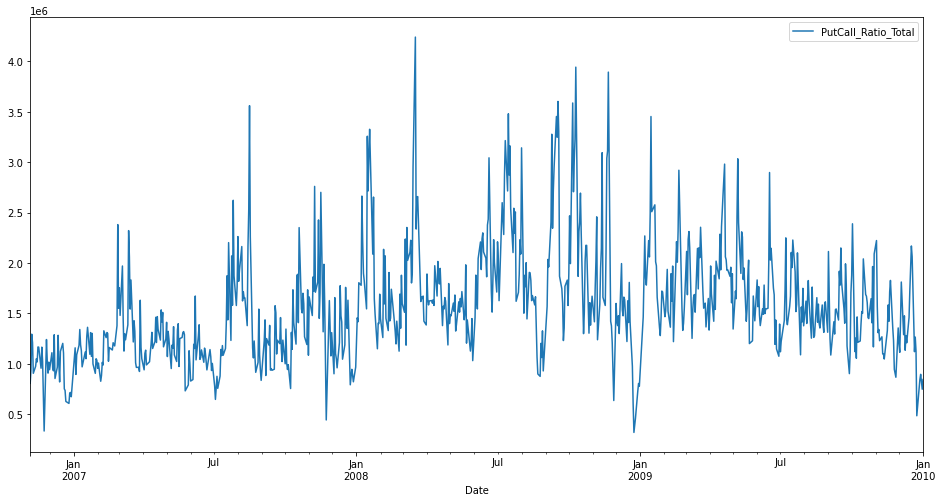

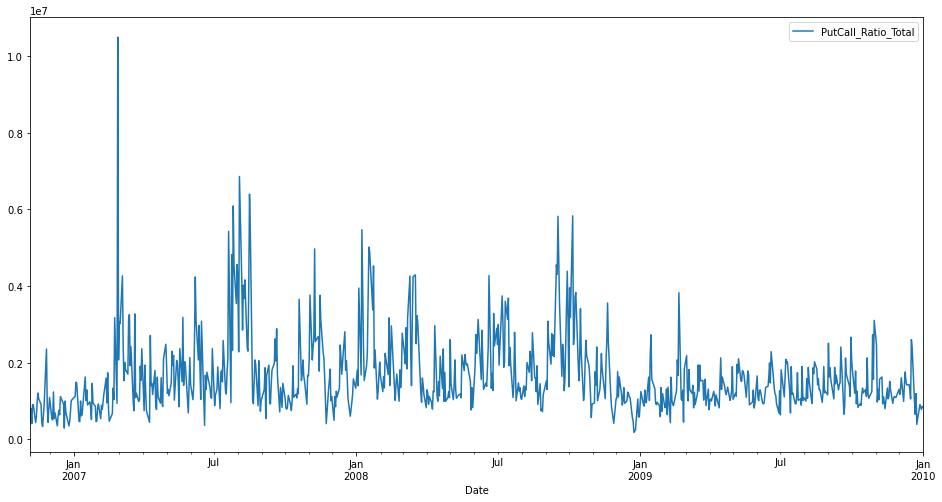

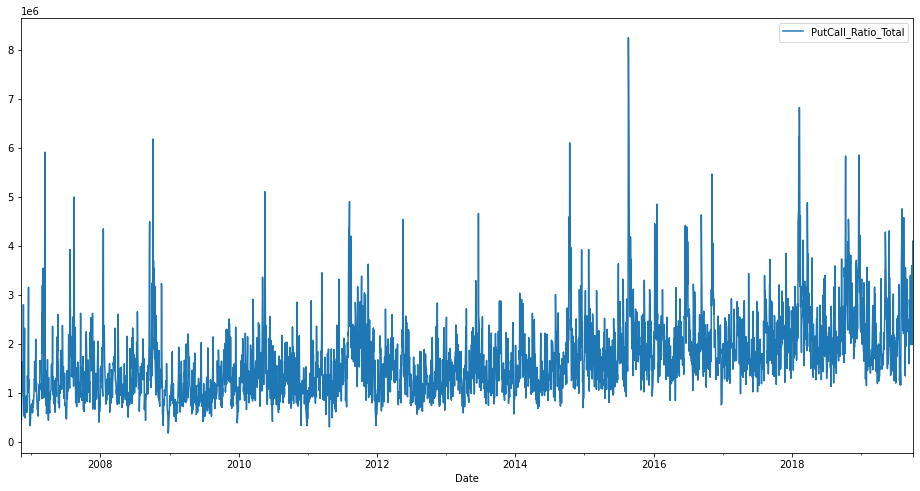

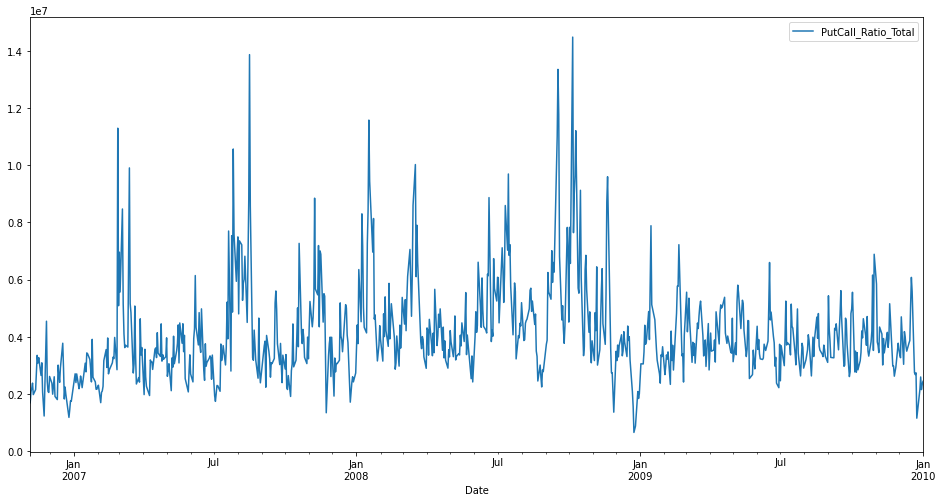

In [23]:
df2_eqto1.plot(figsize=(16,8))

df2_etpo1.plot(figsize=(16,8))
df2_idxo1.plot(figsize=(16,8))
df2_totexo1.plot(figsize=(16,8))

In [24]:
df2_vixo1 = df2_vixo[:'2010-01-01']
df2_vixo1

PutCall_Ratio_Total
Date                           
2006-11-06              2301.52
2006-11-07             25124.80
2006-11-08             16973.38
2006-11-09              6243.72
2006-11-10              1378.42
...                         ...
2009-12-28              7294.70
2009-12-29            152652.72
2009-12-30             44551.46
2009-12-31             45751.04
2010-01-01             52605.96

[1153 rows x 1 columns]

<AxesSubplot:xlabel='Date'>

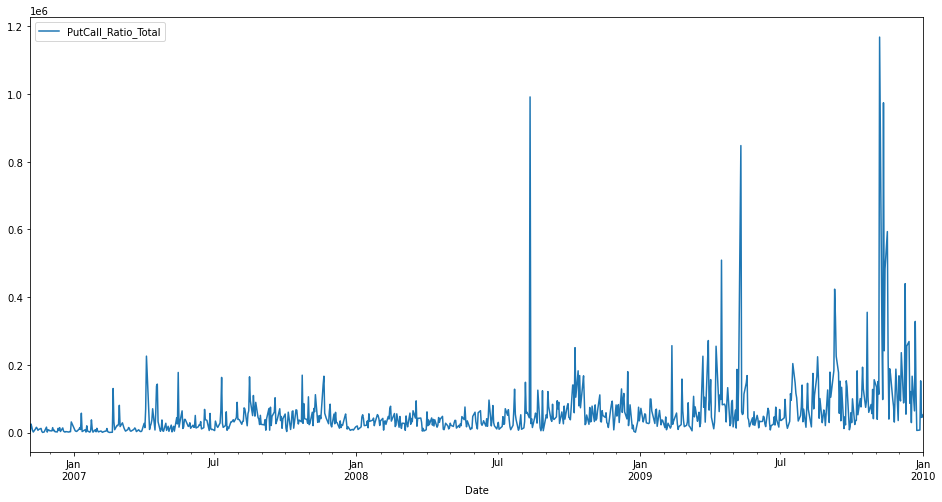

In [25]:
df2_vixo1.plot(figsize=(16,8))